In [0]:
# Connect Google drive with the colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive/DL_Final_Proj')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['train.csv',
 'sample_submission.csv',
 'test',
 'submission.csv',
 'Earthquake.ipynb',
 'Copy of Earthquake.ipynb',
 'Earthquake CNN GRU.ipynb',
 'y_tr',
 'X_tr',
 'Earthquake CNN GRU (1).ipynb']

In [0]:
root = '/content/drive/My Drive/DL_Final_Proj/'

In [0]:
# BASIC IDEA OF THE KERNEL

# The data consists of a one dimensional time series x with 600 Mio data points. 
# At test time, we will see a time series of length 150'000 to predict the next earthquake.
# The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
# features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
# time steps. 

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
float_data = pd.read_csv(root + "train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [0]:
# Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
# Can easily be extended. Expects a two dimensional array.
def extract_features(z):
      z_std = z.std(axis=0)
      z_mean = z.mean(axis=0)
#       x_roll_mean = x.rolling(windows).mean().dropna().values
      return np.c_[z_mean.mean(), 
                  z_mean.min(),
                  z_mean.max(),
                  z_mean.std(),
                  np.quantile(z_mean, 0.01),
                  np.quantile(z_mean, 0.05),
                  np.quantile(z_mean, 0.95),
                  np.quantile(z_mean, 0.99),
                  z_std.mean(), 
                  z_std.min(),
                  z_std.max(),
                  z_std.std(),
                  np.quantile(z_std, 0.01),
                  np.quantile(z_std, 0.05),
                  np.quantile(z_std, 0.95),
                  np.quantile(z_std, 0.99)]

# For a given ending position "last_index", we split the last 150'000 values 
# of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
# From each piece, a set features are extracted. This results in a feature matrix 
# of dimension (150 time steps x features).  
def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:])]

# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
    

Our RNN is based on 48 features


In [0]:
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
# train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


In [0]:
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, CuDNNLSTM
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_2 (CuDNNGRU)       (None, 48)                14112     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               4900      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 20,033
Trainable params: 20,033
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1000/1000 [==============================] - 215s 215ms/step - loss: 2.1051 - val_loss: 1.8656
Epoch 2/10
1000/1000 [==============================] - 205s 205ms/step - loss: 2.1048 - val_loss: 1.6895
Epoch 3/10
1000/1000 [==============================] - 216s 216ms/step - loss: 2.1031 - val_loss: 1.8051
Epoch 4/10
1000/1000 [==============================] - 218s 218ms/step - loss: 2.1014 - val_loss: 1.9724
Epoch 5/10
1000/1000 [==============================] - 218s 218ms/step - loss: 2.1045 - val_loss: 1.7221
Epoch 6/10
1000/1000 [==============================] - 203s 203ms/step - loss: 2.1012 - val_loss: 1.7993
Epoch 7/10
1000/1000 [==============================] - 218s 218ms/step - loss: 2.0989 - val_loss: 1.8000
Epoch 8/10
1000/1000 [==============================] - 220s 220ms/step - loss: 2.1066 - val_loss: 1.7222
Epoch 9/10
1000/1000 [==============================] - 213s 213ms/step - loss: 2.1139 - val_loss: 1.7346
Epoch 10/10
1000/1000 [=======================

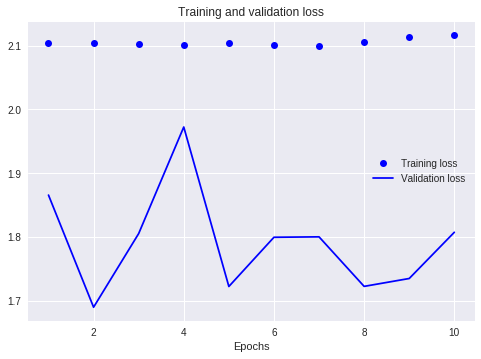

In [0]:
# Compile and fit model
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              verbose=1,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

# Visualize accuracies
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [0]:
import pickle
pickle.dump(model, open(root+'model', 'wb'))

In [0]:
# Load submission file
submission = pd.read_csv(root + 'sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv(root + 'test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv(root +'submission_gru_48features.csv')

NameError: ignored